# <center> Домашняя работа по теме "Оптимизация гиперпараметров модели"

### <center> **Описание задачи**

Необходимо предсказать биологический ответ молекул (столбец `Activity`) по их химическому составу (столбцы `D1-D1776`).

Данные представлены в формате CSV.  Каждая строка представляет молекулу. 

* Первый столбец `Activity` содержит экспериментальные данные, описывающие фактический биологический ответ [0, 1]; 
* Остальные столбцы `D1-D1776` представляют собой молекулярные дескрипторы — это вычисляемые свойства, которые могут фиксировать некоторые характеристики молекулы, например размер, форму или состав элементов.

Предварительная обработка не требуется, данные уже закодированы и нормализованы.

Метрика оценки качества - F1-score.

Необходимо обучить две модели: логистическую регрессию и случайный лес. Далее нужно сделать подбор гиперпараметров с помощью базовых и продвинутых методов оптимизации. Важно использовать все четыре метода (`GridSeachCV, RandomizedSearchCV, Hyperopt, Optuna`) хотя бы по разу, максимальное количество итераций не должно превышать 50.

### <center> **Знакомство с данными и их исследование**

In [200]:
#импорт библиотек
import numpy as np #для матричных вычислений
import pandas as pd #для анализа и предобработки данных
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации

from sklearn import linear_model #линейные моделиё
from sklearn import tree #деревья решений
from sklearn import ensemble #ансамбли
from sklearn import metrics #метрики
from sklearn import preprocessing #предобработка
from sklearn.model_selection import train_test_split #сплитование выборки

#для подбора гиперпараметров
from sklearn.model_selection import GridSearchCV 
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold

#для продвинутой оптимизации
from sklearn.model_selection import cross_val_score
import hyperopt
from hyperopt import hp, fmin, tpe, Trials
import optuna

%matplotlib inline
plt.style.use('seaborn')

In [201]:
#При подборе параметров появляются предупреждения о несовместимости некоторых параметров. Чтобы  они не мешали, мы их отключим.
import warnings
warnings.filterwarnings('ignore')

In [202]:
#подгрузка данных
data = pd.read_csv('data/_train_sem09.csv')
display(data.head())

,Activity,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,D1767,D1768,D1769,D1770,D1771,D1772,D1773,D1774,D1775,D1776
0,1,0.000000,0.497009,0.10,0.0,0.132956,0.678031,0.273166,0.585445,0.743663,...,0,0,0,0,0,0,0,0,0,0
1,1,0.366667,0.606291,0.05,0.0,0.111209,0.803455,0.106105,0.411754,0.836582,...,1,1,1,1,0,1,0,0,1,0
2,1,0.033300,0.480124,0.00,0.0,0.209791,0.610350,0.356453,0.517720,0.679051,...,0,0,0,0,0,0,0,0,0,0
3,1,0.000000,0.538825,0.00,0.5,0.196344,0.724230,0.235606,0.288764,0.805110,...,0,0,0,0,0,0,0,0,0,0
4,0,0.100000,0.517794,0.00,0.0,0.494734,0.781422,0.154361,0.303809,0.812646,...,0,0,0,0,0,0,0,0,0,0


Проверим насколько сбалансировнанны классы:

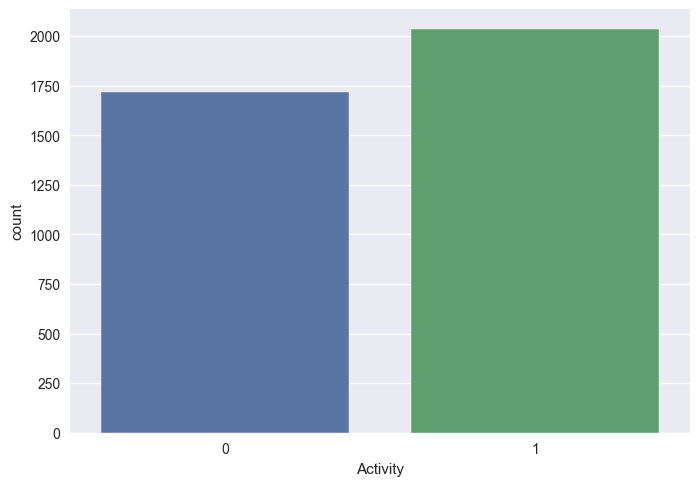

In [203]:
sns.countplot(data=data, x='Activity');

> На графике видно, что есть небольшой перекос в сторону молекул из класса 1, поэтому при разделении выборок на тренировочную и тестовую мы используем стратифицированное разделение. 


Так как данные изначально нормализованы и обработаны, создаем матрицу наблюдений $X$ и вектор ответов $y$

In [204]:
X = data.drop(['Activity'], axis=1)
y = data['Activity']

Разделяем выборку на тренировочную и тестовую в соотношении 80/20. Для сохранения соотношений целевого признака используем параметр stratify (стратифицированное разбиение). 

In [205]:
# зафксируем random_state
random_state = 42

In [206]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = random_state, test_size = 0.2)

### <center> **Оптимизация гиперпараметров модели**

Зафиксируем метрики модели **Логистическая регрессия** без дополнительной настройки, т.е со значениями гиперпараметров по умолчанию, кроме максимального количества итераций. установленного в задании. 

In [207]:
#Создаем объект класса логистическая регрессия
log_reg = linear_model.LogisticRegression(max_iter = 50, random_state=random_state)
#Обучаем модель, минимизируя logloss
log_reg.fit(X_train, y_train)
#получим предсказания модели на тестовом и тренировочном наборе
y_train_pred = log_reg.predict(X_train)
print('f1_score на тренировочной выборке: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
y_test_pred = log_reg.predict(X_test)
print('f1_score на тестовой выборке: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

f1_score на тренировочной выборке: 0.88
f1_score на тестовой выборке: 0.78


> На настройках по умолчанию мы получили обученную модель с результатом метрики $F_1 = 0.78$ на тестовых данных. Попробуем подобрать гиперпараметры, чтобы улучшить данную модель. 

### <center> **GridSearchCV**

In [215]:
#задаём сетку гиперпараметров, из которых будем отбирать лучшие
param_grid = {'penalty': ['l2','none'] ,#тип регурялизации
              'solver': ['lbfgs', 'saga'], #алгоритм оптимизации
              'C': [0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 1], # уровень силы регурялизации
              }
grid_search = GridSearchCV(
    estimator=linear_model.LogisticRegression(
    random_state=random_state, #генератор случайных чисел
    max_iter=50 #количество итераций на сходимость
    ), 
    param_grid=param_grid, 
    cv=5, #ограничиваем количество фолдов 5
    n_jobs = -1, 
    scoring='f1' #задаём метрику
    )  
%time grid_search.fit(X_train, y_train) 
print("f1_score на тренировочной выборке: {:.2f}".format(grid_search.score(X_train, y_train)))
print("f1_score на тестовой  выборке: {:.2f}".format(grid_search.score(X_test, y_test)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search.best_params_))
print("Наилучшее значение точности при кросс-валидаци: {:.2f}".format(grid_search.best_score_))

CPU times: total: 2.28 s
Wall time: 23.7 s
f1_score на тренировочной выборке: 0.82
f1_score на тестовой  выборке: 0.78
Наилучшие значения гиперпараметров: {'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}
Наилучшее значение точности при кросс-валидаци: 0.79


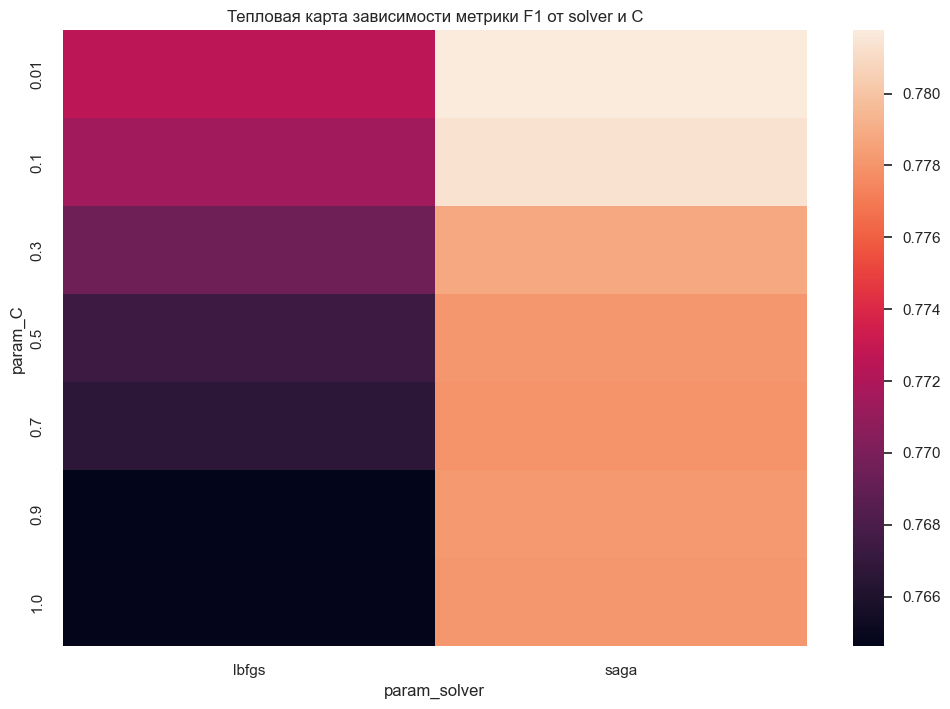

In [216]:
# отрисуем, как менялась точность при различных гиперпараметрах
visual = pd.pivot_table(pd.DataFrame(grid_search.cv_results_),
                        values='mean_test_score', index='param_C',
                        columns='param_solver')
sns.heatmap(visual)
plt.title('Тепловая карта зависимости метрики F1 от solver и С') # подпись графика
sns.set(rc={'figure.figsize':(12, 8)}) #задаем размер графика

> На тепловой карте видно, что лучших результатов мы добились при использовании алгоритмов `saga`, и коэффициента регуляризации `0.01 < C < 0.3`. При этом метрика не изменилась, то есть нам не удалось улучшить модель.
Попробуем сузить границы гиперпараметров и подобрать их снова. 

In [217]:
#задаём более узкую сетку гиперпараметров, из которых будем отбирать лучшие
param_grid = {'penalty': ['l2','none'] ,#тип регурялизации
              'solver': ['lbfgs', 'saga'], #алгоритм оптимизации
              'C': [0.01, 0.015, 0.02, 0.025, 0.03], # уровень силы регурялизации
              }
grid_search = GridSearchCV(
    estimator=linear_model.LogisticRegression(
    random_state=random_state, #генератор случайных чисел
    max_iter=50 #количество итераций на сходимость
    ), 
    param_grid=param_grid, 
    cv=5, #ограничиваем количество фолдов 5
    n_jobs = -1, 
    scoring='f1' #задаём метрику
    )  
%time grid_search.fit(X_train, y_train) 
print("f1_score на тренировочной выборке: {:.2f}".format(grid_search.score(X_train, y_train)))
print("f1_score на тестовой выборке: {:.2f}".format(grid_search.score(X_test, y_test)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search.best_params_))
print("Наилучшее значение точности при кросс-валидаци: {:.2f}".format(grid_search.best_score_))

CPU times: total: 1.62 s
Wall time: 17.9 s
f1_score на тренировочной выборке: 0.83
f1_score на тестовой выборке: 0.78
Наилучшие значения гиперпараметров: {'C': 0.02, 'penalty': 'l2', 'solver': 'lbfgs'}
Наилучшее значение точности при кросс-валидаци: 0.79


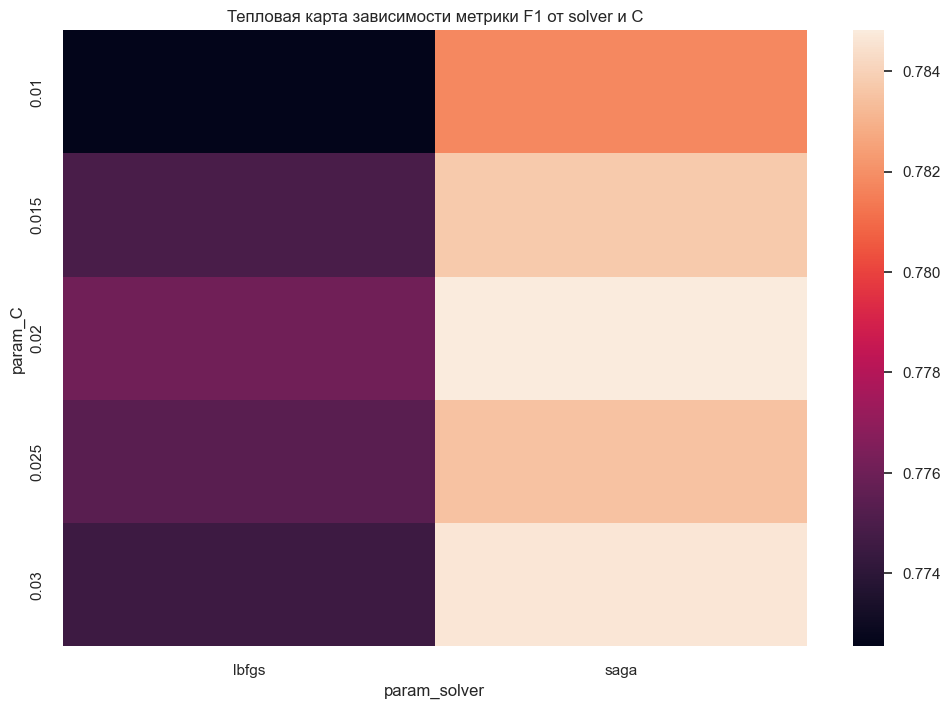

In [218]:
# отрисуем, как менялась точность при различных гиперпараметрах
visual = pd.pivot_table(pd.DataFrame(grid_search.cv_results_),
                        values='mean_test_score', index='param_C',
                        columns='param_solver')
sns.heatmap(visual)
plt.title('Тепловая карта зависимости метрики F1 от solver и С') # подпись графика
sns.set(rc={'figure.figsize':(12, 8)}) #задаем размер графика

> Даже сужение границ сетки гиперпараметров не помогло улучшить метрику. Возможно, наилучшие гиперпараметры просто не попали в сетку. Попробуем подобрать их с помошью `RandomizedSearchCV`.

### <center> **RandomizedSearchCV**

In [219]:
param_distributions = {
    'penalty': ['none','l2'] ,#тип регурялизации
    'solver': ['lbfgs', 'saga'], #алгоритм оптимизации
    'C': [0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3], # уровень силы регурялизации
    },
            
random_search = RandomizedSearchCV(
    estimator=linear_model.LogisticRegression(random_state=random_state, max_iter=50), 
    param_distributions=param_distributions, 
    cv=5, 
    n_iter = 10, 
    n_jobs = -1,
    scoring = 'f1'

)  
%time random_search.fit(X_train, y_train) 
print("F1 на тренировочной выборке: {:.2f}".format(random_search.score(X_train, y_train)))
print("F1 на тестовой выборке: {:.2f}".format(random_search.score(X_test, y_test)))
print("Наилучшие значения гиперпараметров: {}".format(random_search.best_params_))

CPU times: total: 2.25 s
Wall time: 11.9 s
F1 на тренировочной выборке: 0.85
F1 на тестовой выборке: 0.79
Наилучшие значения гиперпараметров: {'solver': 'saga', 'penalty': 'l2', 'C': 0.1}


> К сожалению, даже с помощью `RandomizedSearchCV` нам не удалось улучшить метрику $F_1$. Даже с подобранными гиперпараметрами модель показывает практически тот же результат на тестовой выборке, что и с параметрами по умолчанию.

## <center> **Hyperopt** 

In [220]:
# Настроим оптимизацию гиперпараметров для алгоритма линейной регрессии ориентируясь на предыдущие подобранные параметры
# зададим пространство поиска гиперпараметров
space={'penalty':hp.choice(label='penalty', options=['l2', 'none']),
       'C':hp.loguniform(label='C',  low=-4*np.log(10), high=2*np.log(10)),
       'solver' : hp.choice(label='solver', options=['lbfgs','saga']),
      }

In [221]:
#Интерфейс `hyperopt` отличается от `Grid` или `RandomizedSearch`, поэтому создадим функцию для минимизации,
#она должна принимать словарь значений гиперпараметров и возвращать значение целевой функции.
def hyperopt_rf(params, cv=5, X=X_train, y=y_train, random_state=random_state):
    # функция получает комбинацию гиперпараметров в "params"
    params = {'penalty': str(params['penalty']), 
              'solver': str(params['solver']), 
              'C': float(params['C'])
              }
  
    # используем эту комбинацию для построения модели
    model = linear_model.LogisticRegression(**params, max_iter = 50, random_state=random_state)

    # обучаем модель
    model.fit(X, y)
    score = metrics.f1_score(y, model.predict(X))
    
    # задаём параметры кросс-валидации (стратифицированная с перемешиванием)
    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=random_state)

    # применим  cross validation с тем же количеством фолдов
    score = cross_val_score(model, X, y, cv=skf, scoring="f1", n_jobs=-1).mean()

    # метрику необходимо минимизировать, поэтому ставим знак минус
    return -score

In [ ]:
# начинаем подбор гиперпараметров
trials = Trials() # используется для логирования результатов

best=fmin(hyperopt_rf, # наша функция 
    space=space, # пространство гиперпараметров
    algo=tpe.suggest, # алгоритм оптимизации, установлен по умолчанию, задавать необязательно
    max_evals=20, # максимальное количество итераций
    trials=trials, # логирование результатов
    rstate=np.random.default_rng(random_state)# фиксируем для повторяемости результата
)
print("Наилучшие значения гиперпараметров {}".format(best))

100%|██████████| 20/20 [00:59<00:00,  3.00s/trial, best loss: -0.7855273194376095]
Наилучшие значения гиперпараметров {'C': 0.07644393107925136, 'penalty': 0, 'solver': 1}


In [222]:
if best['penalty'] == 0: penalty_hp='l2'
elif best['penalty'] == 1: penalty_hp='none'

if best['solver'] == 0: solver_hp='lbfgs'
elif best['solver'] == 1: solver_hp='saga'

# рассчитаем точность для тестовой выборки
model = linear_model.LogisticRegression(
    random_state=random_state, 
    max_iter=50,
    penalty=penalty_hp,
    C=float(best['C']),
    solver=solver_hp
)
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
print("f1_score на тренировочной выборке: {:.2f}".format(model.score(X_train, y_train)))
print("f1_score на тестовой выборке: {:.2f}".format(model.score(X_test, y_test)))

f1_score на тренировочной выборке: 0.83
f1_score на тестовой выборке: 0.76


> Даже с помощью метода `hyperopt` нам не удалось улучшить метрику. Остаётся одна наджеда на `optuna`

## <center> Optuna

In [231]:
# Настроим оптимизацию гиперпараметров 
def optuna_rf(trial):
  # задаем пространства поиска гиперпараметров
  penalty = trial.suggest_categorical('penalty', ['none', 'l2'])
  C = trial.suggest_float('C', 0.01, 1)
  solver = trial.suggest_categorical('solver', ['saga', 'lbfgs'])

  # создаем модель
  model = linear_model.LogisticRegression(solver=solver,
                                          penalty=penalty,
                                          C=C,
                                          max_iter=50,
                                          random_state=random_state)
  # обучаем модель
  model.fit(X_train, y_train)
  score = metrics.f1_score(y_train, model.predict(X_train))

  return score

In [232]:
# cоздаем объект исследования
# можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
study = optuna.create_study(study_name="LogisticRegression", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_rf, n_trials=20)

[I 2023-05-05 12:21:46,526] A new study created in memory with name: LogisticRegression
[I 2023-05-05 12:21:46,826] Trial 0 finished with value: 0.880683552029295 and parameters: {'penalty': 'none', 'C': 0.7864230015210966, 'solver': 'lbfgs'}. Best is trial 0 with value: 0.880683552029295.
[I 2023-05-05 12:21:47,122] Trial 1 finished with value: 0.880683552029295 and parameters: {'penalty': 'none', 'C': 0.18840659559704387, 'solver': 'lbfgs'}. Best is trial 0 with value: 0.880683552029295.
[I 2023-05-05 12:21:49,243] Trial 2 finished with value: 0.8654369519201692 and parameters: {'penalty': 'l2', 'C': 0.6527683359895765, 'solver': 'saga'}. Best is trial 0 with value: 0.880683552029295.
[I 2023-05-05 12:21:49,536] Trial 3 finished with value: 0.880683552029295 and parameters: {'penalty': 'none', 'C': 0.5241251084135894, 'solver': 'lbfgs'}. Best is trial 0 with value: 0.880683552029295.
[I 2023-05-05 12:21:49,818] Trial 4 finished with value: 0.880683552029295 and parameters: {'penalty'

In [233]:
# выводим результаты на обучающей выборке
print("Наилучшие значения гиперпараметров {}".format(study.best_params))
print("f1_score на тренировочной выборке: {:.2f}".format(study.best_value))

Наилучшие значения гиперпараметров {'penalty': 'none', 'C': 0.7864230015210966, 'solver': 'lbfgs'}
f1_score на тренировочной выборке: 0.88


In [234]:
# рассчитаем точность для тестовой выборки
model = linear_model.LogisticRegression(**study.best_params,random_state=random_state, max_iter=50)
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
print('f1_score на тренировочной выборке: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
y_test_pred = model.predict(X_test)
print('f1_score на тестовой выборке: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

f1_score на тренировочной выборке: 0.88
f1_score на тестовой выборке: 0.77


> Наилучший результат по метрике $F_1 = 0.79$ нам удалось достичь с помошью и `RandomizedSearchCV` гиперпараметров {'solver': 'saga', 'penalty': 'l2', 'C': 0.1}. Возможно, всё дело в неверно подобранной модели. Построим модель `RandomForestClassifier` и оценим её качество с помощью метрики $F_1$ 

### <center> **Случайный лес**

Попробуем постмроить модель RandomForestClassifier(). Для начала оценим метрику f1 с гиперпараметрами по умолчанию.

In [235]:
#Создаем объект класса случайный лес
rf = ensemble.RandomForestClassifier(random_state=random_state)

#Обучаем модель
rf.fit(X_train, y_train)
#Выводим значения метрики 
y_train_pred = rf.predict(X_train)
print('f1_score на тренировочной выборке: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
y_test_pred = rf.predict(X_test)
print('f1_score на тестовой выборке: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

f1_score на тренировочной выборке: 1.00
f1_score на тестовой выборке: 0.80


> Даже с параметрами по умолчанию нам удалось добиться более высокого значения метрики на тестовой выборке, но судя по метрике, полученной на тренировочной выборке, моджель переобучена и полностью подстроилась под полученные данные. Попробем подобрать гиперпараметры, чтобы избежать этого.

### <center> **GridSearchCV**

In [274]:
#np.linspace(start(от), stop(до), num(количество), dtype - тип данных)
param_grid = {'n_estimators': list(range(80, 200, 30)),
              'min_samples_leaf': [5, 10, 15],
              'max_depth': list(np.linspace(20, 40, 5, dtype=int))
              }
            
grid_search_forest = GridSearchCV(
    estimator=ensemble.RandomForestClassifier(random_state=random_state), 
    param_grid=param_grid, 
    cv=5, 
    n_jobs = -1,
    scoring = 'f1'
)  
%time grid_search_forest.fit(X_train, y_train)  
print('f1_score на тренировочной выборке: {:.2f}'.format(grid_search_forest.score(X_train, y_train)))
print("f1_score на тестовой выборке: {:.2f}".format(grid_search_forest.score(X_test, y_test)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search_forest.best_params_))

CPU times: total: 3.48 s
Wall time: 55.3 s
f1_score на тренировочной выборке: 0.95
f1_score на тестовой выборке: 0.81
Наилучшие значения гиперпараметров: {'max_depth': 30, 'min_samples_leaf': 5, 'n_estimators': 170}


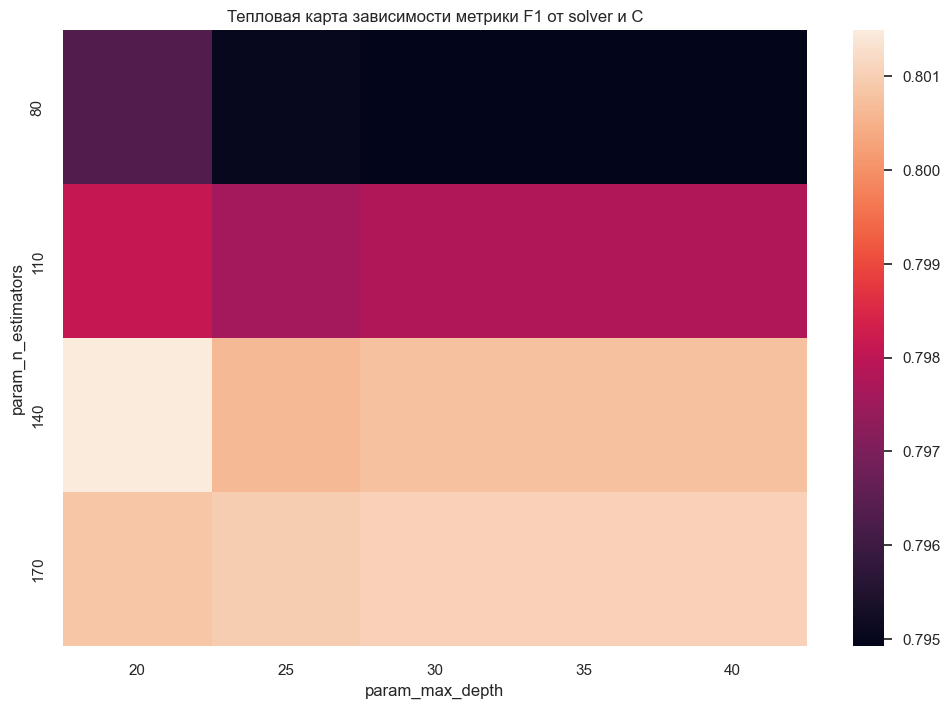

In [237]:
# отрисуем, как менялась точность при различных гиперпараметрах
visual = pd.pivot_table(pd.DataFrame(grid_search_forest.cv_results_),
                        values='mean_test_score', index='param_n_estimators',
                        columns='param_max_depth')
sns.heatmap(visual)
plt.title('Тепловая карта зависимости метрики F1 от solver и С') # подпись графика
sns.set(rc={'figure.figsize':(12, 8)}) #задаем размер графика

> Нам удалось не только улучшить метрику на тестовой выборке, но и снизить метрику на тренировочной выборке, а значит уменьшить переобучение модели.  Попробуем сузить сетку гиперпараметров и подобрать их вновь

In [273]:
#np.linspace(start(от), stop(до), num(количество), dtype - тип данных)
param_grid = {'n_estimators': list(range(140, 180, 10)),
              'min_samples_leaf': [4,5,6],
              'max_depth': list(np.linspace(20, 41, 5, dtype=int))
              }
            
grid_search_forest = GridSearchCV(
    estimator=ensemble.RandomForestClassifier(random_state=random_state), 
    param_grid=param_grid, 
    cv=5, 
    n_jobs = -1,
    scoring = 'f1'
)  
%time grid_search_forest.fit(X_train, y_train)  
print('f1_score на тренировочной выборке: {:.2f}'.format(grid_search_forest.score(X_train, y_train)))
print("f1_score на тестовой выборке: {:.2f}".format(grid_search_forest.score(X_test, y_test)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search_forest.best_params_))

CPU times: total: 2.75 s
Wall time: 1min 16s
f1_score на тренировочной выборке: 0.93
f1_score на тестовой выборке: 0.80
Наилучшие значения гиперпараметров: {'max_depth': 20, 'min_samples_leaf': 6, 'n_estimators': 140}


> Значительных успехов добиться не удалось. Значение метрики $F_1$ на тестовой и тренировочной выборке чуть снизилось. Попробуем подобрать гиперпараметры с помощью метода `RandomizedSearchCV`, который так хорошо показал себя на модели Линейной регрессии

### <center> **RandomizedSearchCV**

In [272]:
#np.linspace(start(от), stop(до), num(количество), dtype - тип данных)
param_distributions = {'n_estimators': list(range(80, 200, 30)),
              'min_samples_leaf': [5, 10, 15],
              'max_depth': list(np.linspace(20, 40, 10, dtype=int))
              }
            
random_search_forest = RandomizedSearchCV(
    estimator=ensemble.RandomForestClassifier(random_state=random_state), 
    param_distributions=param_distributions, 
    cv=5,
    n_iter = 10, 
    n_jobs = -1,
    scoring = 'f1'
)  
%time random_search_forest.fit(X_train, y_train) 
print('f1_score на тренировочной выборке: {:.2f}'.format(random_search_forest.score(X_train, y_train)))
print("f1_score на тестовой выборке: {:.2f}".format(random_search_forest.score(X_test, y_test)))
print("Наилучшие значения гиперпараметров: {}".format(random_search_forest.best_params_))

CPU times: total: 2.56 s
Wall time: 15.8 s
f1_score на тренировочной выборке: 0.95
f1_score на тестовой выборке: 0.81
Наилучшие значения гиперпараметров: {'n_estimators': 170, 'min_samples_leaf': 5, 'max_depth': 33}


> С помощью метода `RandomizedSearchCV` мы получили мтерику $F_1=0.81$ примерно с теми же параметрами, что мы получили и с помощью метода `GridSearchCV`, возможно, это наилучшее значение для нашей модели. Проверим это с помощью методов продвинутой оптимизации.

### <center> Hyperopt

In [243]:
# Настроим оптимизацию гиперпараметров для алгоритма случайного леса ориентируясь на предыдущие подобранные параметры
space={'n_estimators': hp.quniform('n_estimators', 100, 200, 1),
       'max_depth' : hp.quniform('max_depth', 15, 26, 1),
       'min_samples_leaf': hp.quniform('min_samples_leaf', 2, 10, 1)
      }

In [245]:
#Интерфейс `hyperopt` отличается от `Grid` или `RandomizedSearch`, поэтому создадим функцию для минимизации,
#она должна принимать словарь значений гиперпараметров и возвращать значение целевой функции.
def hyperopt_rf(params, cv=5, X=X_train, y=y_train, random_state=random_state):
    # функция получает комбинацию гиперпараметров в "params"
    params = {'n_estimators': int(params['n_estimators']), 
              'max_depth': int(params['max_depth']), 
             'min_samples_leaf': int(params['min_samples_leaf'])
              }
  
    # используем эту комбинацию для построения модели
    model = ensemble.RandomForestClassifier(**params, random_state=random_state)

    # обучаем модель
    model.fit(X, y)
    score = metrics.f1_score(y, model.predict(X))
    
    # применим  cross validation с тем же количеством фолдов
    score = cross_val_score(model, X, y, cv=cv, scoring="f1", n_jobs=-1).mean()

    # метрику необходимо минимизировать, поэтому ставим знак минус
    return -score

In [250]:
# начинаем подбор гиперпараметров
trials = Trials() # используется для логирования результатов

best=fmin(hyperopt_rf, # наша функция 
    space=space, # пространство гиперпараметров
    algo=tpe.suggest, # алгоритм оптимизации, установлен по умолчанию, задавать необязательно
    max_evals=20, # максимальное количество итераций
    trials=trials, # логирование результатов
    rstate=np.random.default_rng(random_state)# фиксируем для повторяемости результата
)
print("Наилучшие значения гиперпараметров {}".format(best))

100%|██████████| 20/20 [01:25<00:00,  4.29s/trial, best loss: -0.8160803811393121]
Наилучшие значения гиперпараметров {'max_depth': 18.0, 'min_samples_leaf': 2.0, 'n_estimators': 103.0}


In [251]:
# рассчитаем точность для тестовой выборки
model = ensemble.RandomForestClassifier(
    random_state=random_state, 
    n_estimators=int(best['n_estimators']),
    max_depth=int(best['max_depth']),
    min_samples_leaf=int(best['min_samples_leaf'])
)
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
print('f1_score на тренировочной выборке: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
y_test_pred = model.predict(X_test)
print('f1_score на тестовой выборке: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

f1_score на тренировочной выборке: 0.99
f1_score на тестовой выборке: 0.81


> Хоть мы и получили мтерику $F_1=0.81$ на тестовой выборке, но на тернировочной выборке метрика снова увеличилась, что говорит о переобучении модели.

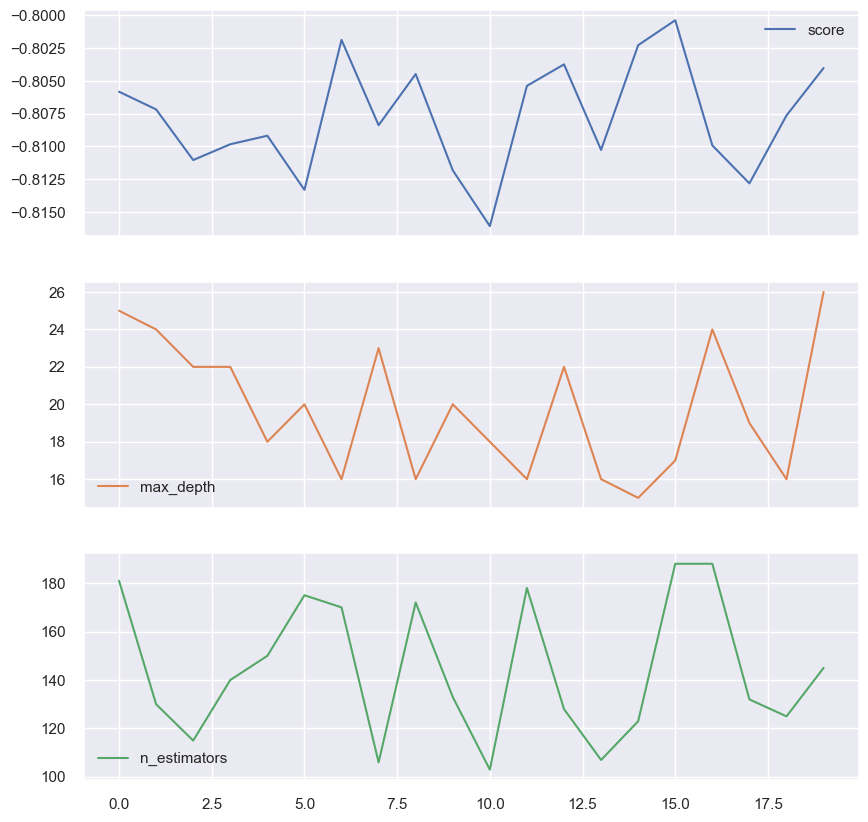

In [252]:
# отрисуем, как менялась точность при различных гиперпараметрах
tpe_results=np.array([[x['result']['loss'],
                      x['misc']['vals']['max_depth'][0],
                      x['misc']['vals']['n_estimators'][0]] for x in trials.trials])

tpe_results_df=pd.DataFrame(tpe_results,
                           columns=['score', 'max_depth', 'n_estimators'])
# тепловая карта в данном случае не очень наглядна, возьмем линейный график
tpe_results_df.plot(subplots=True,figsize=(10, 10));

## <center> Optuna

In [256]:
def optuna_rf(trial):
  # задаем пространства поиска гиперпараметров
  n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
  max_depth = trial.suggest_int('max_depth', 10, 30, 1)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)

  # создаем модель
  model = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          random_state=random_state)
  # обучаем модель
  model.fit(X_train, y_train)
  score = metrics.f1_score(y_train, model.predict(X_train))

  return score  

In [266]:
%%time
# cоздаем объект исследования
# можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
study = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_rf, n_trials=20)

[I 2023-05-05 12:41:26,458] A new study created in memory with name: RandomForestClassifier
[I 2023-05-05 12:41:28,541] Trial 0 finished with value: 0.9287454323995127 and parameters: {'n_estimators': 139, 'max_depth': 23, 'min_samples_leaf': 6}. Best is trial 0 with value: 0.9287454323995127.
[I 2023-05-05 12:41:30,537] Trial 1 finished with value: 0.9031866464339908 and parameters: {'n_estimators': 152, 'max_depth': 23, 'min_samples_leaf': 9}. Best is trial 0 with value: 0.9287454323995127.
[I 2023-05-05 12:41:32,247] Trial 2 finished with value: 0.9725106902871106 and parameters: {'n_estimators': 101, 'max_depth': 22, 'min_samples_leaf': 3}. Best is trial 2 with value: 0.9725106902871106.
[I 2023-05-05 12:41:34,806] Trial 3 finished with value: 0.9019726858877086 and parameters: {'n_estimators': 193, 'max_depth': 30, 'min_samples_leaf': 9}. Best is trial 2 with value: 0.9725106902871106.
[I 2023-05-05 12:41:36,429] Trial 4 finished with value: 0.9199391171993911 and parameters: {'n_

CPU times: total: 46.8 s
Wall time: 46.9 s


In [267]:
# выводим результаты на обучающей выборке
print("Наилучшие значения гиперпараметров {}".format(study.best_params))
print("f1_score тренировочной выборке: {:.2f}".format(study.best_value))

Наилучшие значения гиперпараметров {'n_estimators': 168, 'max_depth': 17, 'min_samples_leaf': 2}
f1_score тренировочной выборке: 0.99


In [268]:
# рассчитаем точность для тестовой выборки
model = ensemble.RandomForestClassifier(**study.best_params,random_state=random_state)
model.fit(X_train, y_train)
print("f1_score на тренировочной выборке: {:.2f}".format(model.score(X_train, y_train)))
print("f1_score на тестовой выборке: {:.2f}".format(model.score(X_test, y_test)))

f1_score на тренировочной выборке: 0.98
f1_score на тестовой выборке: 0.78


> К сожалению, методы продвинутой оптимизации не помогли нам улучшить метрику.

## <center> Выводы

Наилучшего результата по метрике $F_1=0.81$ мы добились при построении модели `RandomForestClassifier` и подбора гиперпараметров с помощью методов `GridSearchCV` и `RandomizedSearchCV`. Стоит отметить, что при подборе параметров с помощью методов продвинутой оптимизации они всегда стримятся добитсья максмимума метрики, что приводит к переобучению модели и более низким результатам на тестовой выборке. 

Оптимальными параметрами для построения модели я бы выбрала `RandomForestClassifier(max_depth=20, min_samples_leaf=6, n_estimators=140)` либо `RandomForestClassifier(max_depth=30, min_samples_leaf=5, n_estimators=170)` так как это позволяет получить не переобученную модель с высокими показателями метрики на тестовой выборке. 